# COMP309 Capstone Project
#### Marrick Lip, 2019

## [0] Setup

### 0.1 Get the dependencies

In [1]:
#%%capture
# ^ hide the output

!conda update --all --yes
!conda install cudnn --yes

!pip install --upgrade pip
!pip install tensorflow-gpu
!pip install imutils
!pip install tqdm
!pip install pyyaml h5py
!pip install tensorflow-hub

Solving environment: | 
  - conda-forge::libgfortran-3.0.0-1
  - defaults::libgfortran-3.0.0done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/tensorflow_p36


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    nose-1.3.7                 |           py36_2         214 KB
    multipledispatch-0.6.0     |           py36_0          21 KB
    mkl-service-2.3.0          |   py36he904b0f_0         208 KB
    spyder-3.3.6               |           py36_0         2.5 MB
    pytest-doctestplus-0.4.0   |             py_0          18 KB
    libtool-2.4.6              |       h7b6447c_5         513 KB
    locket-0.2.0               |           py36_1           8 KB
    anaconda-client-1.7.2    

nose-1.3.7           | 214 KB    | ##################################### | 100% 
multipledispatch-0.6 | 21 KB     | ##################################### | 100% 
mkl-service-2.3.0    | 208 KB    | ##################################### | 100% 
spyder-3.3.6         | 2.5 MB    | ##################################### | 100% 
pytest-doctestplus-0 | 18 KB     | ##################################### | 100% 
libtool-2.4.6        | 513 KB    | ##################################### | 100% 
locket-0.2.0         | 8 KB      | ##################################### | 100% 
anaconda-client-1.7. | 141 KB    | ##################################### | 100% 
chardet-3.0.4        | 197 KB    | ##################################### | 100% 
pandas-0.25.2        | 11.4 MB   | ##################################### | 100% 
pytest-remotedata-0. | 15 KB     | ##################################### | 100% 
pytest-5.0.1         | 353 KB    | ##################################### | 100% 
attrs-19.3.0         | 39 KB

odo-0.5.1            | 193 KB    | ##################################### | 100% 
sphinxcontrib-1.0    | 3 KB      | ##################################### | 100% 
libopus-1.3          | 631 KB    | ##################################### | 100% 
bazel-0.26.1         | 38.0 MB   | ##################################### | 100% 
click-7.0            | 118 KB    | ##################################### | 100% 
mkl_fft-1.0.14       | 173 KB    | ##################################### | 100% 
dask-2.6.0           | 12 KB     | ##################################### | 100% 
seaborn-0.9.0        | 379 KB    | ##################################### | 100% 
alabaster-0.7.12     | 17 KB     | ##################################### | 100% 
atomicwrites-1.3.0   | 13 KB     | ##################################### | 100% 
fastcache-1.1.0      | 31 KB     | ##################################### | 100% 
asn1crypto-1.2.0     | 162 KB    | ##################################### | 100% 
pycodestyle-2.5.0    | 60 KB

cudatoolkit-10.1.168 | 516.0 MB  | ##################################### | 100% 
cudnn-7.6.0          | 240.9 MB  | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.3.1)
     |████████████████████████████████| 380.8MB 20kB/s s eta 0:00:01
     |████████████████████████████████| 71kB 1.1MB/s  eta 0:00:01
     |████████████████████████████████| 450kB 36.3MB/s eta 0:00:01
     |████████████████████████████████| 3.8MB 39.3MB/s eta 0:00:01
  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp36-none-any.whl size=61682 sha256=986c4ecf7d776291b194b18590939ffff9e5a5daa9d1c5a0761b4f30661872f4
  Stored in directory: /home/ec2-user/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
Successfully built opt-einsum
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0

### 0.2 Import the dependencies

In [52]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob
import imageio
import random
import math
import shutil
import requests
import skimage
import uuid

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import tensorflow_hub as hub
from collections import defaultdict

# create a directory if it doesn't already exist
make_dir = lambda path: os.path.exists(path) or os.makedirs(path)

### 0.3 Constants

In [3]:
IMG_HEIGHT = 224 #300 
IMG_WIDTH = 224 # 300
train_pct = 0.7
batch_size = 24

## [1] Get the Data

### 1.1 Create directories for the test and train data

In [4]:
!rm -rf data
make_dir('data')
make_dir('data/train')
make_dir('data/test')

### 1.1 Get the provided dataset

#### 1.1.1 Download and unzip the images

In [5]:
if not os.path.exists('train.zip'):
    !curl https://ecs.victoria.ac.nz/foswiki/pub/Courses/COMP309_2019T2/Assignments/Train_data_2019.zip -o train.zip
!unzip -oq train.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.5M  100 67.5M    0     0   949k      0  0:01:12  0:01:12 --:--:--  980k


#### 1.1.2 Split the images using 309 as a seed

In [6]:
random.seed(309)
for label_dir in glob.glob('data/Train_data/*'):
    label = label_dir.split('/')[-1]
    make_dir(f'data/train/{label}')
    make_dir(f'data/test/{label}')
    
    images = glob.glob(f'{label_dir}/*')
    random.shuffle(images)
    
    split_index = math.floor(len(images) * train_pct)
    for i, image in tqdm(enumerate(images), label):
        train_or_test = 'train' if i < split_index else 'test'
        new_path = image.replace('Train_data', train_or_test)
        shutil.move(image, new_path)

# clean-up the unzipped directory (will be empty)
!rm -rf data/Train_data
!rm -rf data/__MACOSX

### 1.2 Get images from ImageNet

#### 1.2.1 Fetch the ImageNet urls

In [7]:
!ls imagenet_urls/

ls: cannot access imagenet_urls/: No such file or directory


In [8]:
imagenet_urls_path = 'imagenet_urls/fall11_urls.txt'
if not os.path.exists(imagenet_urls_path):
    !rm -rf imagenet_urls 
    !mkdir imagenet_urls

    # n.b. the main site is down: use a mirror
    !wget https://v.im.cyut.edu.tw/ftp/18/imagenet_fall11_urls.tgz -O imagenet_urls/imagenet_fall11_urls.tgz
    !tar -xvf imagenet_urls/imagenet_fall11_urls.tgz -C imagenet_urls

raw_image_urls = list(open(imagenet_urls_path, encoding='ISO-8859-1'))

--2019-10-28 01:10:13--  https://v.im.cyut.edu.tw/ftp/18/imagenet_fall11_urls.tgz
Resolving v.im.cyut.edu.tw (v.im.cyut.edu.tw)... 163.17.9.3
Connecting to v.im.cyut.edu.tw (v.im.cyut.edu.tw)|163.17.9.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350302759 (334M) [application/x-gzip]
Saving to: ‘imagenet_urls/imagenet_fall11_urls.tgz’

imagenet_urls/image 100%[===================>] 334.07M  15.0MB/s    in 19s     

2019-10-28 01:10:33 (17.3 MB/s) - ‘imagenet_urls/imagenet_fall11_urls.tgz’ saved [350302759/350302759]

fall11_urls.txt


#### 1.2.2 Find images for each class

In [9]:
word_net_ids = {
    'strawberry': ['n07745940'],
    'cherry': ['n07757132', 'n07757312', 'n07757874', 'n07757990'],
    'tomato': ['n07734292', 'n07734292']
}

image_urls_by_class = defaultdict(list)
for line in tqdm(raw_image_urls):
    image_id = line.split('\t')[0].split('_')[0]
    image_url = line.split('\t')[1].strip()
    
    for class_name, ids in word_net_ids.items():
        if image_id in ids:
            image_urls_by_class[class_name] += [image_url]

#### 1.2.3 Download applicable images from ImageNet
Note: images from Flickr are filtered out as they may be in the evaluation data set.

In [10]:
try:
    dead_images
except:
    dead_images = [] # don't retry these again this session
    
for class_name, urls in image_urls_by_class.items():
    # filter out images from flickr
    not_flickr = [url for url in urls if 'flickr' not in url]
    for i, url in tqdm(list(enumerate(not_flickr)), class_name):
        extension = url.split('.')[-1].lower()
        if extension not in ['jpg', 'jpeg', 'png']: continue
        
        out_image_path = f'data/train/{class_name}/image_net_{i:03}.jpg'
        if os.path.exists(out_image_path) or url in dead_images:
            continue
        
        try:
            response = requests.get(url, timeout=(2, 5), allow_redirects=False)
            assert response.status_code == 200
        except (
            AssertionError, # status code wasn't 200
            requests.exceptions.ReadTimeout,
            requests.exceptions.ConnectionError,
            requests.exceptions.Timeout
        ): # can't download image
            dead_images += [url]
            continue
            
        temp_file_name = f'temp.{extension}'
        open(temp_file_name, 'wb').write(response.content)
        
        try:
            image = imageio.imread(temp_file_name)
            if image.shape[-1] == 4:
                image = skimage.color.rgba2rgb(image)
            
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)
            imageio.imwrite(out_image_path, image)
        except ValueError: # isn't a valid image
            dead_images += [url]
            continue
        finally:
            os.remove(temp_file_name)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


### 1.3 Process images from Google Images

In [11]:
# this is manually uploaded
!unzip -oq google_images.zip

all_images = enumerate(glob.glob('google_images/*/*'))
for i, image_path in tqdm(list(all_images)):
    class_name = image_path.split('/')[-2].replace('cherry_tomato', 'tomato')
    
    image = imageio.imread(image_path)
    imageio.imwrite(f'data/train/{class_name}/google_images_{i:04}.jpg', image)
    
!rm -rf google_images

## [2] Pre-processing

### 2.1 Specify the data augmentation to use

In [13]:
data_augmentation = dict(
    horizontal_flip=True,
    rotation_range=35,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.1,
    shear_range=25,
    brightness_range=[0.75, 1.25],
)

### 2.2 Build the ImageDataGenerators
Note: the test data isn't augmented here, but TTA is later implemented

In [14]:
print('Train:', end=' ')
train_data_gen = ImageDataGenerator(rescale=1.0/255, **data_augmentation).flow_from_directory(
    batch_size=batch_size,
    directory='data/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

print('Test:', end=' ')
test_data_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    batch_size=batch_size,
    directory='data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

Train: Found 5534 images belonging to 3 classes.
Test: Found 900 images belonging to 3 classes.


### 2.3 Visualise the data augmentation

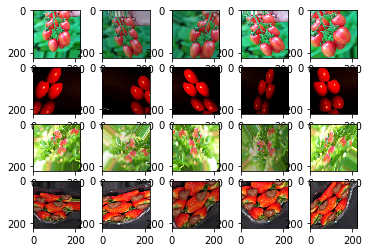

In [15]:
_, axes = plt.subplots(4, 5)

for image in range(axes.shape[0]):
    for example in tqdm(range(axes.shape[1])):
        axes[image,example].imshow(train_data_gen[0][0][image])

## [3] Training

### 3.1 Create a transfer learning model

In [16]:
train_histories = []

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False # freeze the pre-trained bit

# wrap the model in a sequential model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.AveragePooling2D(),
    Flatten(),
    Dropout(0.25),
    Dense(3, activation='softmax'),
])

9412608/9406464 [==============================] - 2s 0us/step


### 3.2 Train the trail of the model

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=15,
)

train_histories.append(r.history)

Epoch 1/15
231/231 [==============================] - 104s 452ms/step - loss: 0.9385 - accuracy: 0.7461 - val_loss: 1.1174 - val_accuracy: 0.7578
Epoch 2/15
231/231 [==============================] - 98s 425ms/step - loss: 0.8917 - accuracy: 0.7900 - val_loss: 0.8730 - val_accuracy: 0.8089
Epoch 3/15
231/231 [==============================] - 97s 421ms/step - loss: 0.9170 - accuracy: 0.8010 - val_loss: 0.8560 - val_accuracy: 0.8489
Epoch 4/15
231/231 [==============================] - 97s 421ms/step - loss: 1.0109 - accuracy: 0.8016 - val_loss: 1.5869 - val_accuracy: 0.7733
Epoch 5/15
231/231 [==============================] - 97s 421ms/step - loss: 0.8964 - accuracy: 0.8235 - val_loss: 1.1960 - val_accuracy: 0.8267
Epoch 6/15
231/231 [==============================] - 94s 409ms/step - loss: 1.0494 - accuracy: 0.8148 - val_loss: 0.8337 - val_accuracy: 0.8711
Epoch 7/15
231/231 [==============================] - 97s 419ms/step - loss: 1.0192 - accuracy: 0.8216 - val_loss: 1.1852 - val_a

### 3.3 Unfreeze some of the pre-trained model and continue training

In [18]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    initial_epoch=15,
    epochs=30,
)

train_histories.append(r.history)

Epoch 16/30
231/231 [==============================] - 104s 452ms/step - loss: 1.0984 - accuracy: 0.8430 - val_loss: 1.1337 - val_accuracy: 0.8567
Epoch 17/30
231/231 [==============================] - 102s 442ms/step - loss: 1.0103 - accuracy: 0.8551 - val_loss: 1.0404 - val_accuracy: 0.8644
Epoch 18/30
231/231 [==============================] - 101s 439ms/step - loss: 0.9034 - accuracy: 0.8605 - val_loss: 1.0078 - val_accuracy: 0.8644
Epoch 19/30
231/231 [==============================] - 101s 438ms/step - loss: 0.8783 - accuracy: 0.8683 - val_loss: 1.0387 - val_accuracy: 0.8633
Epoch 20/30
231/231 [==============================] - 102s 440ms/step - loss: 0.8546 - accuracy: 0.8683 - val_loss: 1.0773 - val_accuracy: 0.8556
Epoch 21/30
231/231 [==============================] - 101s 435ms/step - loss: 0.7796 - accuracy: 0.8737 - val_loss: 1.0115 - val_accuracy: 0.8644
Epoch 22/30
231/231 [==============================] - 100s 431ms/step - loss: 0.7807 - accuracy: 0.8786 - val_loss: 0

### 3.4 Unfreeze more of the pre-trained model and continue training

In [68]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=3e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    initial_epoch=30,
    epochs=40,
)

train_histories.append(r.history)

Epoch 31/40
231/231 [==============================] - 109s 470ms/step - loss: 0.4871 - accuracy: 0.9051 - val_loss: 0.8327 - val_accuracy: 0.8811
Epoch 32/40
231/231 [==============================] - 108s 468ms/step - loss: 0.4688 - accuracy: 0.9109 - val_loss: 0.8079 - val_accuracy: 0.8811
Epoch 33/40
231/231 [==============================] - 108s 466ms/step - loss: 0.4475 - accuracy: 0.9106 - val_loss: 0.7966 - val_accuracy: 0.8778
Epoch 34/40
231/231 [==============================] - 106s 459ms/step - loss: 0.4476 - accuracy: 0.9080 - val_loss: 0.7841 - val_accuracy: 0.8811
Epoch 35/40
231/231 [==============================] - 107s 464ms/step - loss: 0.4731 - accuracy: 0.9087 - val_loss: 0.7790 - val_accuracy: 0.8789
Epoch 36/40
231/231 [==============================] - 107s 461ms/step - loss: 0.4617 - accuracy: 0.9143 - val_loss: 0.7910 - val_accuracy: 0.8767
Epoch 37/40
231/231 [==============================] - 107s 465ms/step - loss: 0.4123 - accuracy: 0.9145 - val_loss: 0

### 3.5 Save the model

In [69]:
make_dir('models')

model_id = str(uuid.uuid4()).split('-')[0]
model.save(f'models/{model_id}.h5')

### 3.6 Visualise the training history

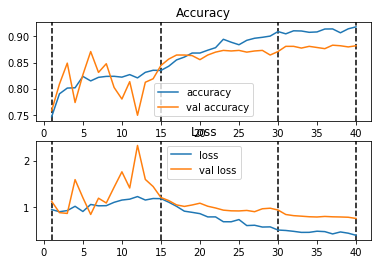

In [72]:
ANY_SERIES = list(train_histories[0].keys())[0] # arbitrary key

fig, (ax_accuracy, ax_loss) = plt.subplots(2, 1)

n_epochs = sum(len(history[ANY_SERIES]) for history in train_histories)
epochs = np.arange(1, n_epochs + 1)

series = defaultdict(list)
phase_boundaries = [1]
for history in train_histories:
    for series_name, values in history.items():
        series[series_name] += values
    phase_boundaries += [len(series[ANY_SERIES])]
        
for phase_boundary in phase_boundaries:
    for ax in [ax_accuracy, ax_loss]:
        ax.axvline(
            phase_boundary,
            color='black',
            linestyle='--'
        )
        
ax_accuracy.set_title('Accuracy')
ax_accuracy.plot(epochs, series['accuracy'], label='accuracy')
ax_accuracy.plot(epochs, series['val_accuracy'], label='val accuracy')
ax_accuracy.legend()

ax_loss.set_title('Loss')
ax_loss.plot(epochs, series['loss'], label='loss')
ax_loss.plot(epochs, series['val_loss'], label='val loss')
ax_loss.legend()

plt.savefig(f'models/{model_id}.png', dpi=300)